In [1]:
import abm
from functools import reduce
import plotnine as p9
import pandas as pd
import numpy as np
from fractions import Fraction

# Simulate one-at-a-time sensitivity analysis

In [2]:
mpk = 0.01 # mg/kg
interval = 21. # d
dose_count = 7

doses = pd.DataFrame([
    {'route': 'SC_mpk', 'amounts': [mpk], 'times': np.arange(0, dose_count*interval, interval).tolist(), 'amount_unit': 'mg/kg', 'time_unit': 'd'}
])

doses

,route,amounts,times,amount_unit,time_unit
0,SC_mpk,[0.01],"[0.0, 21.0, 42.0, 63.0, 84.0, 105.0, 126.0]",mg/kg,d


In [3]:
parameters = pd.read_csv('./Tables/par_table_psf_tornado.csv')

parameter_updates = dict(
    interval = (interval, 'd'),
    dose = (mpk, 'mg/kg'),
    dose_count = (dose_count, '1')
)
parameter_updates['start_output_time'] = (interval * (dose_count - 1), 'd')
parameter_updates['stop_output_time'] = (interval * dose_count, 'd')

for par, (val, unit) in parameter_updates.items():
    is_par = parameters.parameter == par
    assert sum(is_par) <= 1 # Check for duplicates
    if sum(is_par) == 1: # parameter exists in table
        parameters.loc[is_par, "value"] = val
        parameters.loc[is_par, "unit"] = unit
    else: # parameter doesn't exist in table
        parameters = pd.concat([
            parameters,
            pd.DataFrame([{'binding_strength': '*', 'burden': '*', 'parameter': par, 'value': val, 'unit': unit}])
        ])

parameters

,binding_strength,burden,parameter,value,unit
0,*,*,volume_central,5.000000e+00,L
1,*,low,R1_per_cell,1.000000e+04,1
2,*,high,R1_per_cell,1.000000e+06,1
3,*,*,cell_per_mL,1.000000e+04,(1/mL)
4,*,*,kon,1.000000e-03,(1/nM/s)
5,strong,*,kd_mab,1.000000e-01,nM
6,weak,*,kd_mab,2.000000e+00,nM
7,*,*,el_half,2.800000e+01,d
8,*,*,abs_half,2.500000e+00,d
9,*,*,R1_half,6.000000e+01,min


In [4]:
simulations = pd.DataFrame([{'binding_strength': 'strong', 'burden': 'low'}])

In [5]:
# Print the parameters alongside some reasonable starting fold changes so I can copy-paste
# them below to start my scan definitions
for par in parameters.parameter.unique():
    print(f"{par!r}: [[1./3, 3.], 'description'],")

'volume_central': [[1./3, 3.], 'description'],
'R1_per_cell': [[1./3, 3.], 'description'],
'cell_per_mL': [[1./3, 3.], 'description'],
'kon': [[1./3, 3.], 'description'],
'kd_mab': [[1./3, 3.], 'description'],
'el_half': [[1./3, 3.], 'description'],
'abs_half': [[1./3, 3.], 'description'],
'R1_half': [[1./3, 3.], 'description'],
'BW': [[1./3, 3.], 'description'],
'mw': [[1./3, 3.], 'description'],
'interval': [[1./3, 3.], 'description'],
'dose': [[1./3, 3.], 'description'],
'dose_count': [[1./3, 3.], 'description'],
'Thalf_cytokine_h': [[1./3, 3.], 'description'],
'RO50_perc': [[1./3, 3.], 'description'],
'ksecrete_max_nmolpercellsec': [[1./3, 3.], 'description'],
'nonexist': [[1./3, 3.], 'description'],
'start_output_time': [[1./3, 3.], 'description'],
'stop_output_time': [[1./3, 3.], 'description'],


In [6]:
scan_parameters = {
    'volume_central': [[1./2, 2.], 'Compartment volume'],
    'R1_per_cell': [[1./3, 3.], ' # receptors per cell'],
    'cell_per_mL': [[1./3, 3.], 'Cell density'],
    'kon': [[1./3, 3.], 'Association rate constant'],
    'kd_mab': [[1./3, 3.], 'K$_D$'],
    'el_half': [[1./3, 3.], 'Linear elim. half-life'],
    'abs_half': [[1./3, 3.], 'SC absorption half-time'],
    'R1_half': [[1./3, 3.], 'Receptor internalization half-life'],
    # 'BW': [[1./3, 3.], 'description'],
    # 'mw': [[1./3, 3.], 'description'],
    # 'interval': [[1./3, 3.], 'description'],
    # 'dose': [[1./3, 3.], 'description'],
    # 'dose_count': [[1./3, 3.], 'description'],
    # 'start_output_time': [[1./3, 3.], 'description'],
    # 'stop_output_time': [[1./3, 3.], 'description'],
    'Thalf_cytokine_h': [[1./3, 3.], 'Cytokine elim. half-life'],
    'RO50_perc': [[1./3, 3.], 'RO achieving 50% cytokine release rate'],
    'ksecrete_max_nmolpercellsec': [[1./3, 3.], 'Max cytokine secretion rate']
}

scan_oat = reduce(
    lambda x, y: x + y, 
    (abm.fold_scan(**{par: folds}) for par, [folds, _] in scan_parameters.items())
)

In [7]:
nice_output_names = {
    'mean_receptor_occupancy': 'Average receptor occupancy over the final dose interval (%)',
    'receptor_occupancy': 'Receptor occupancy at the end of the final dose interval (%)'
}

In [8]:
def run_scans(scans):
    return abm.simulate(
        models='./Model_Files/antireceptor_model_1compartment.model',
        simulations=simulations,
        parameters=parameters,
        doses=doses,
        scans=scans,
        times=[f"{interval*dose_count}:d"],
        outputs=list(nice_output_names.keys())
    ).to_pandas(tall_outputs=True)

Tout = run_scans(scan_oat)
Tnom = run_scans(abm._scan.NoScan())

Tnom = Tnom.rename(columns={'value': 'nominal_value'}).drop(columns=['id'])

Tout = Tout.merge(Tnom, how='left', on=['binding_strength', 'burden', 't', 'output', 'output_unit'])

Tout

/opt/pixi/cache/envs/abm-platform-training-11393412784987863449/envs/default/lib/python3.12/site-packages/abm/_simulate.py:355: UserWarning: Parameters not present in the model will be ignored: nonexist 


Total: 0, Running: 0, Succeeded: 0, Failed: 0

/opt/pixi/cache/envs/abm-platform-training-11393412784987863449/envs/default/lib/python3.12/site-packages/abm/_simulate.py:355: UserWarning: Parameters not present in the model will be ignored: nonexist 


Total: 0, Running: 0, Succeeded: 0, Failed: 0

,binding_strength,burden,scan_0_type,id,param_scan_0,scan_0_value,scan_0_fold,t,output,value,output_unit,nominal_value
0,strong,low,fold,0,volume_central,2.500000e+00,0.500000,12700800.0,mean_receptor_occupancy,92.000484,1,84.877702
1,strong,low,fold,0,volume_central,2.500000e+00,0.500000,12700800.0,receptor_occupancy,90.607115,1,82.402430
2,strong,low,fold,1,volume_central,1.000000e+01,2.000000,12700800.0,mean_receptor_occupancy,72.973897,1,84.877702
3,strong,low,fold,1,volume_central,1.000000e+01,2.000000,12700800.0,receptor_occupancy,69.057657,1,82.402430
4,strong,low,fold,2,R1_per_cell,3.333333e+03,0.333333,12700800.0,mean_receptor_occupancy,85.334506,1,84.877702
5,strong,low,fold,2,R1_per_cell,3.333333e+03,0.333333,12700800.0,receptor_occupancy,83.020249,1,82.402430
6,strong,low,fold,3,R1_per_cell,3.000000e+04,3.000000,12700800.0,mean_receptor_occupancy,83.359146,1,84.877702
7,strong,low,fold,3,R1_per_cell,3.000000e+04,3.000000,12700800.0,receptor_occupancy,80.304995,1,82.402430
8,strong,low,fold,4,cell_per_mL,3.333333e+03,0.333333,12700800.0,mean_receptor_occupancy,85.334506,1,84.877702
9,strong,low,fold,4,cell_per_mL,3.333333e+03,0.333333,12700800.0,receptor_occupancy,83.020249,1,82.402430


# Generate tornado plot

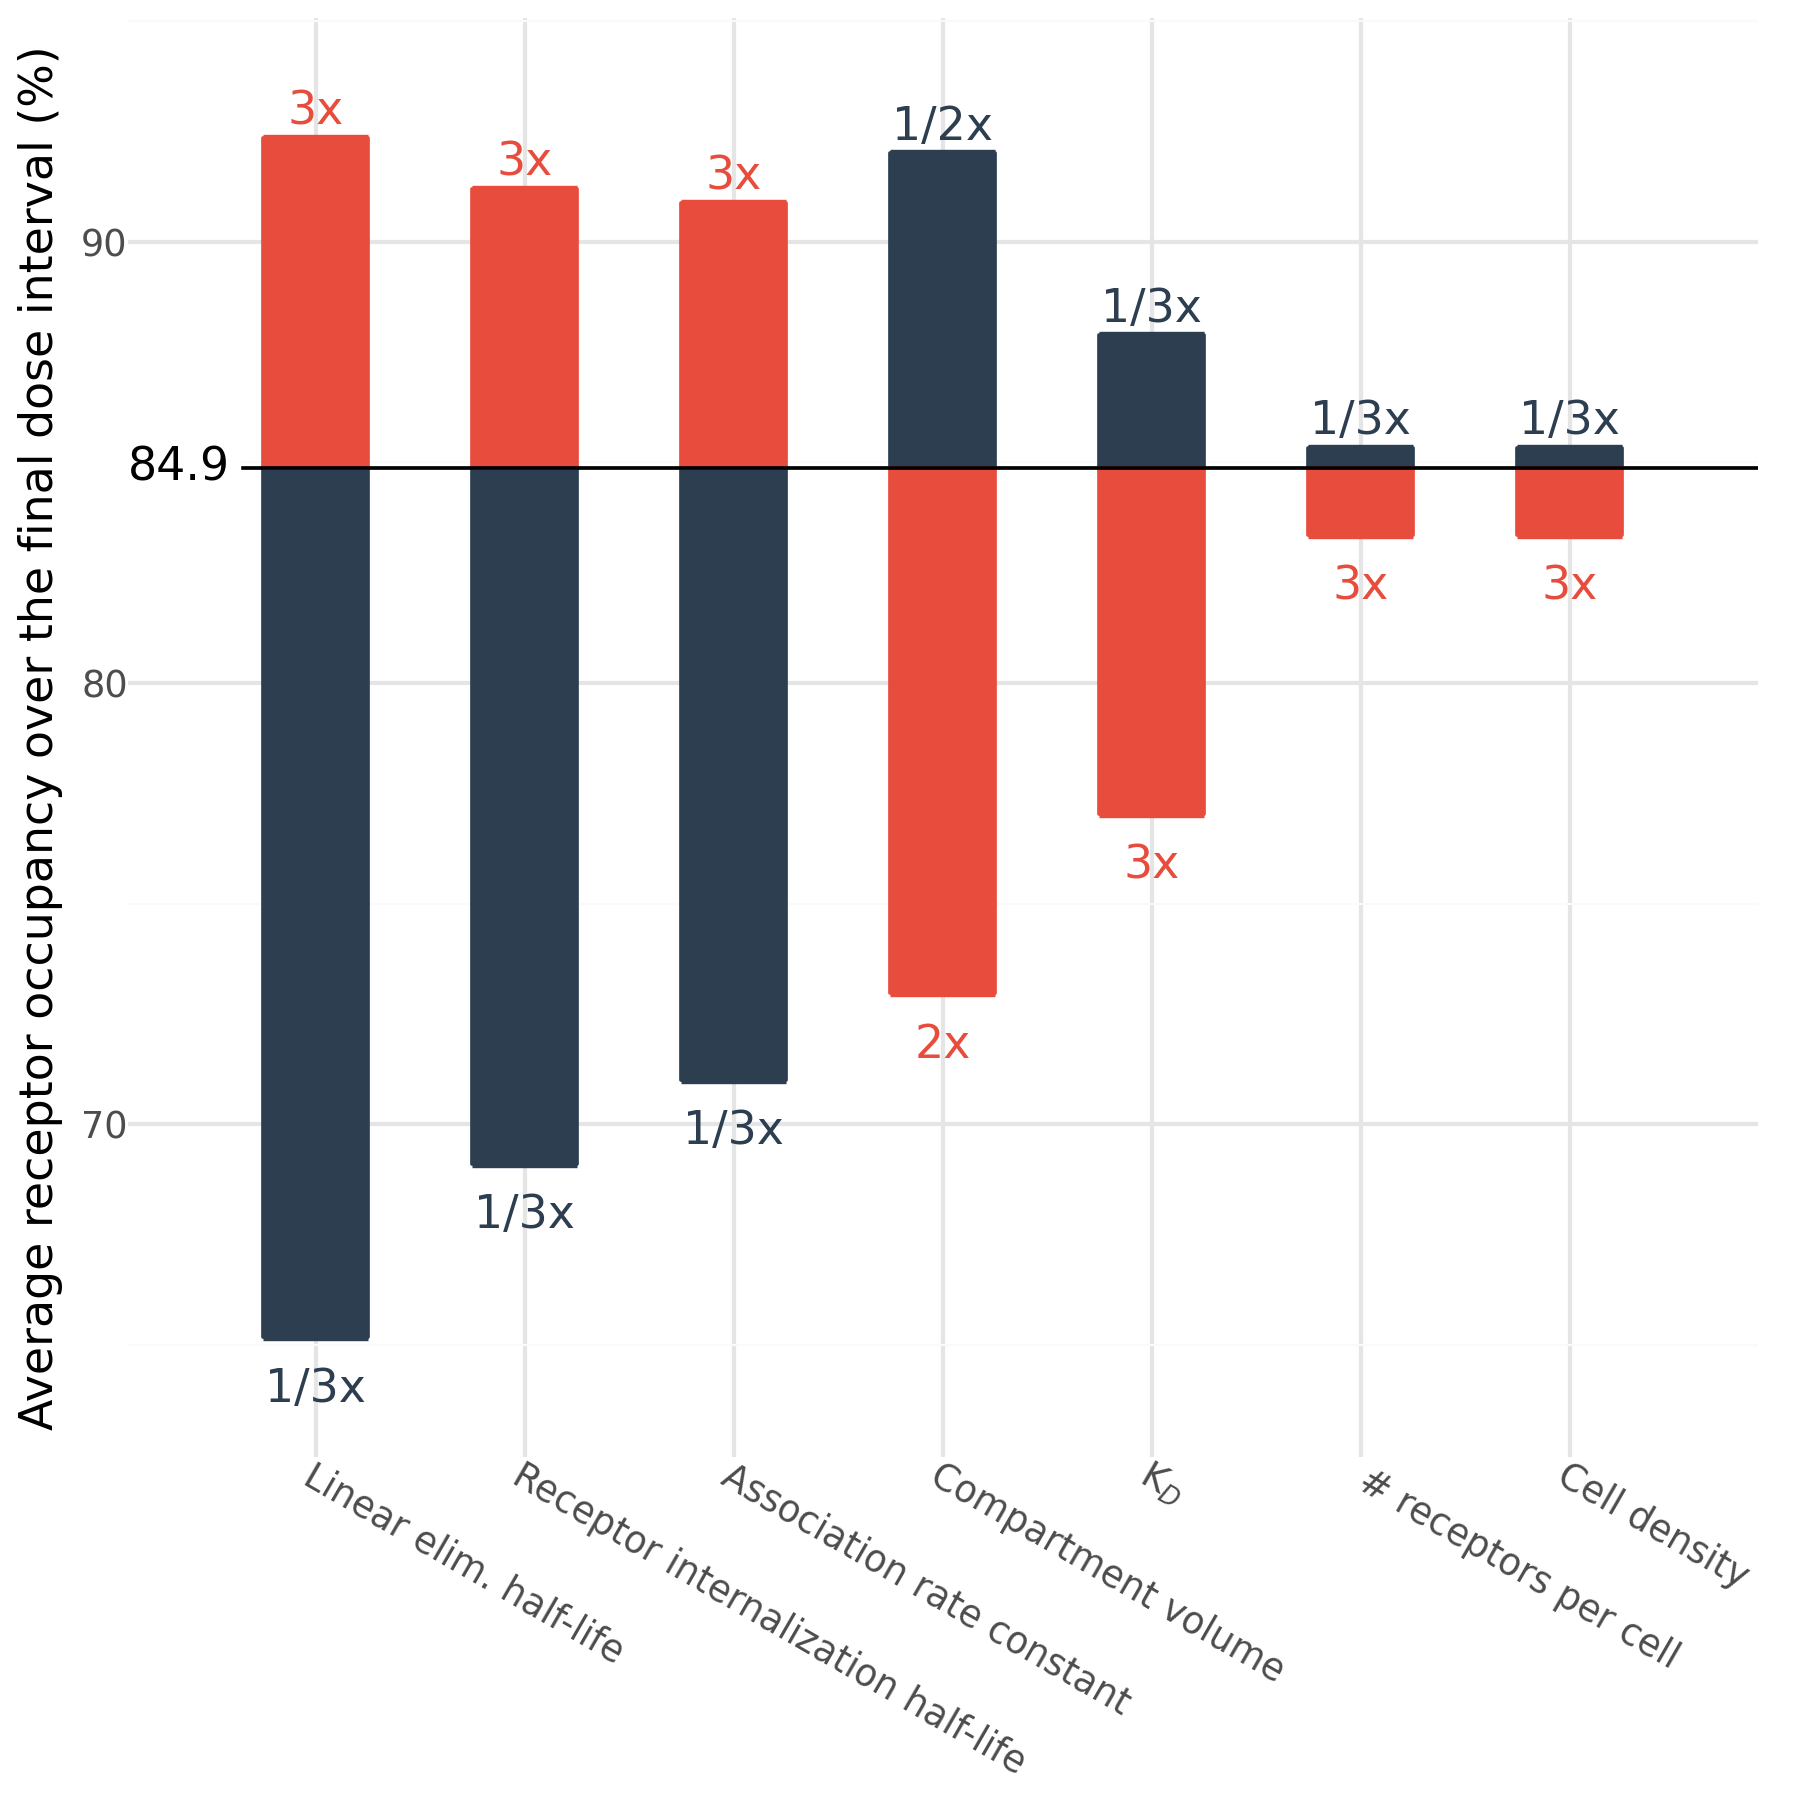

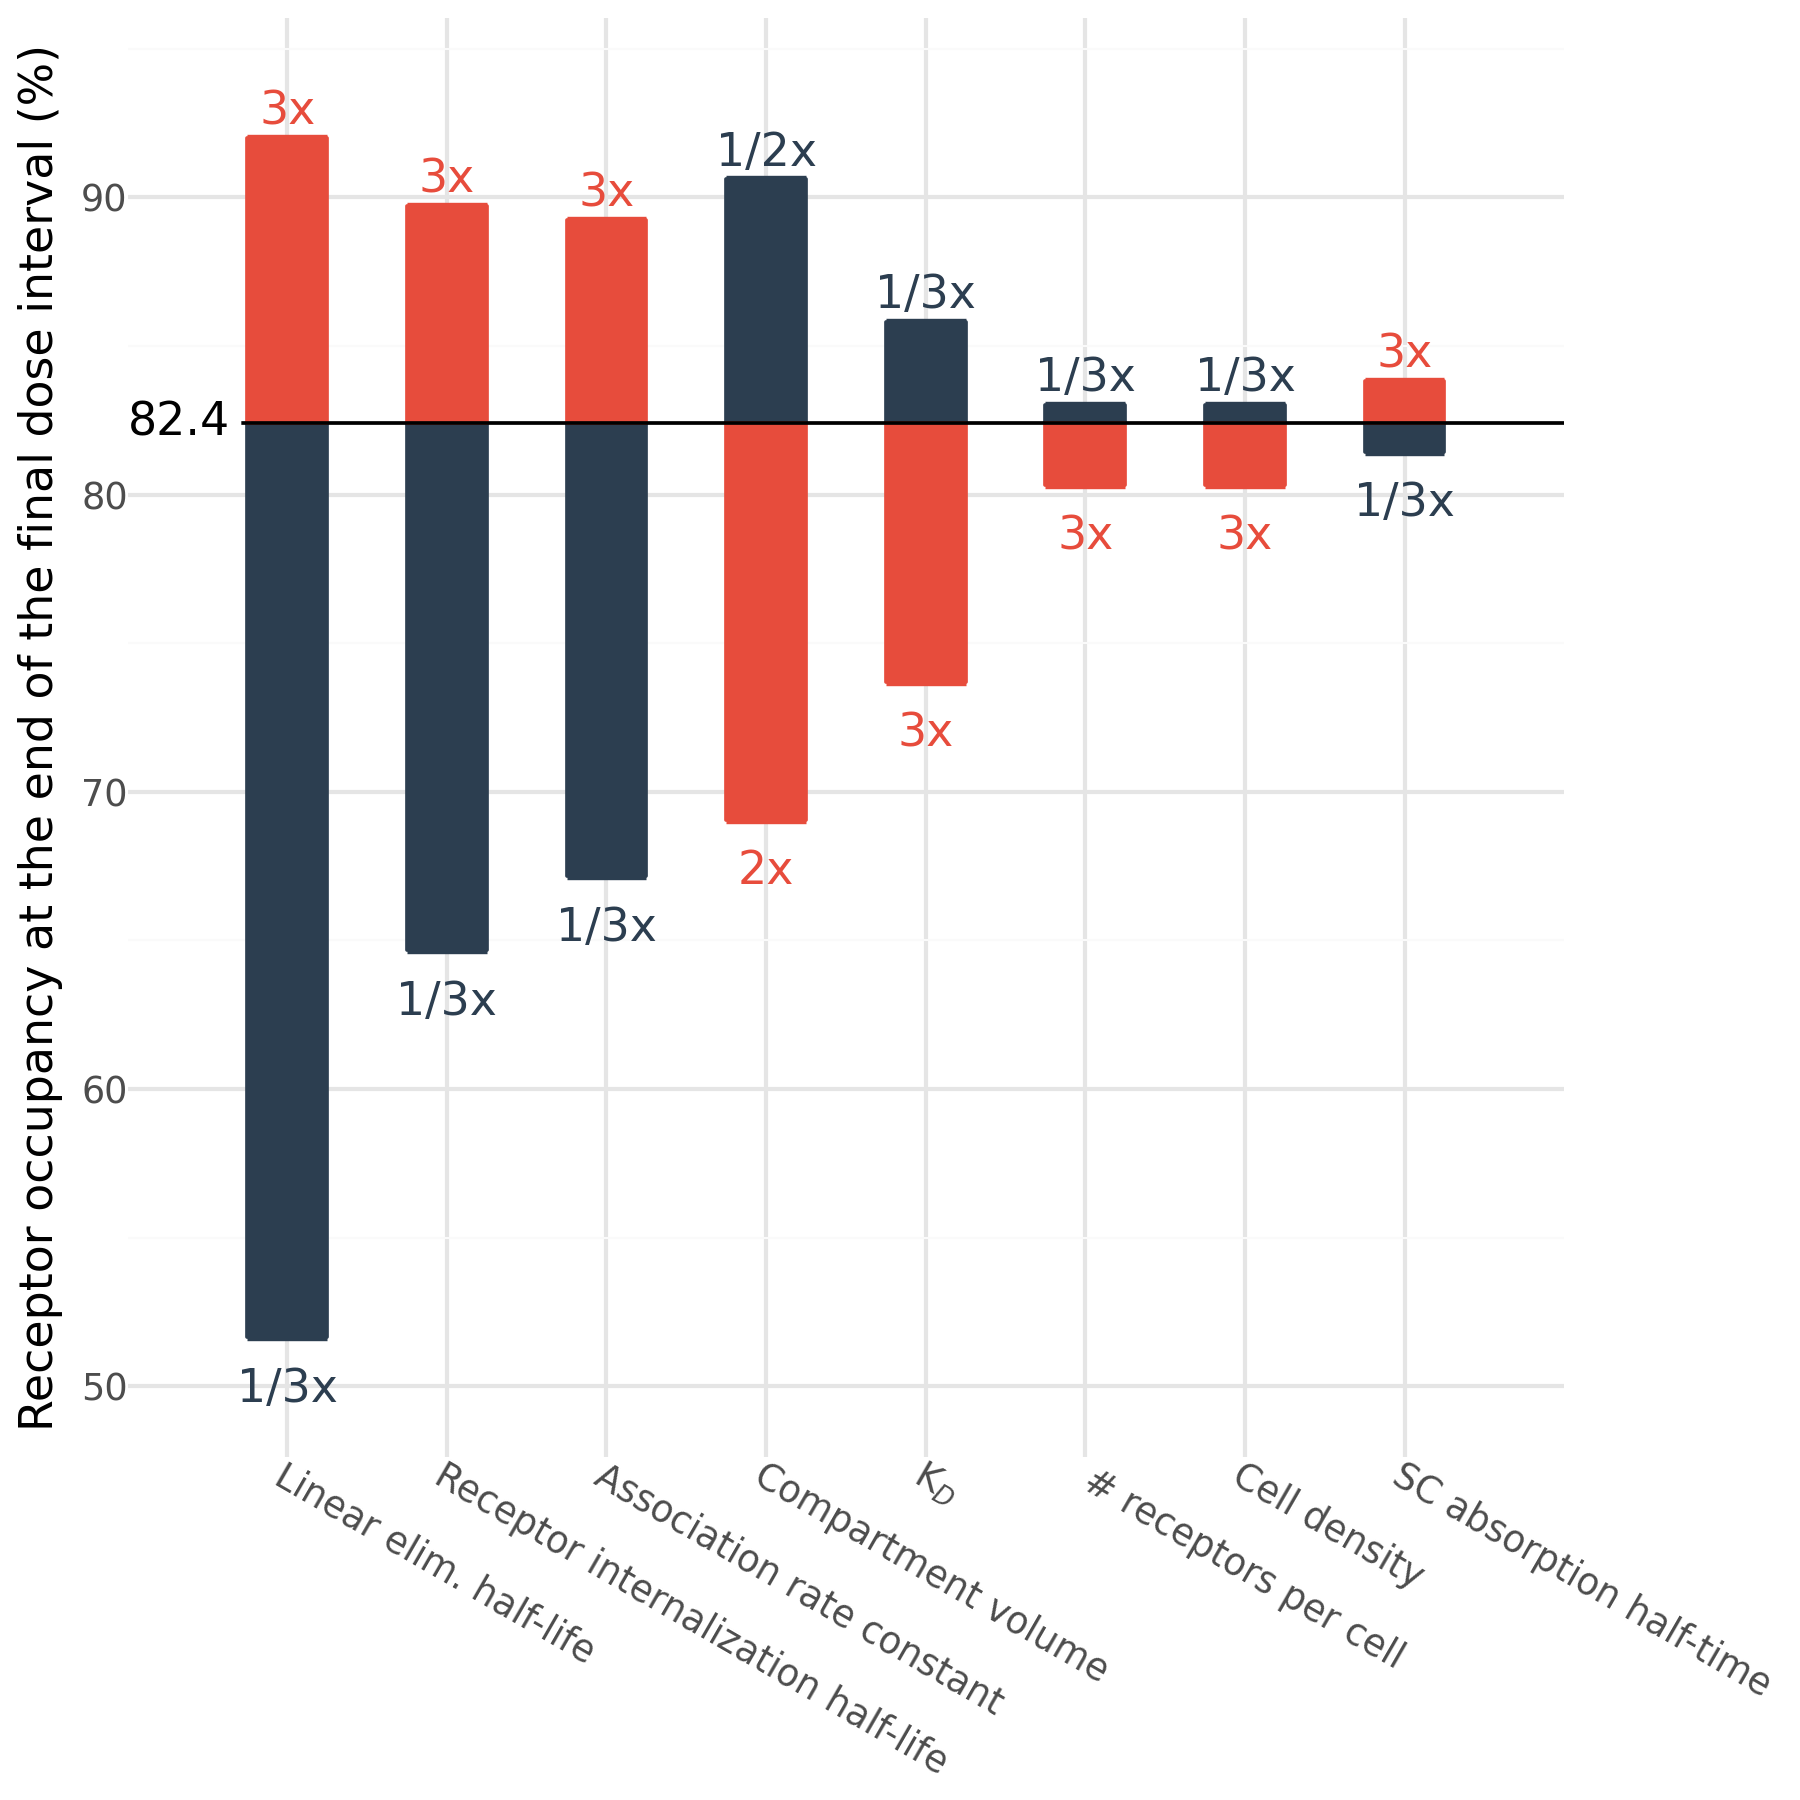

In [9]:
for output, df in Tout.groupby('output'):

    df['fold_fraction'] = [Fraction(fold).limit_denominator(10) for fold in df.scan_0_fold]

    sensitivity_metrics = (
        df.groupby('param_scan_0')
        .apply(lambda df: max(df.value.max(), df.nominal_value.max()) - min(df.value.min(), df.nominal_value.min()),
              include_groups=False)
        .sort_values(ascending=False)
    )
    sensitivity_metrics = sensitivity_metrics[sensitivity_metrics > 0.05*sensitivity_metrics.max()] # Keep only those parameters in the plot that are at least 5% as sensitive as the most sensitive parameter
    parameter_order = sensitivity_metrics.index.to_list()
    df = df.query('param_scan_0.isin(@parameter_order)')

    nominal_value = df.nominal_value.iloc[0]
    assert all(nominal_value == df.nominal_value)

    display(
        p9.ggplot(df, p9.aes('param_scan_0', y='value', ymin='nominal_value', ymax='value', color='fold_fraction > 1', fill='fold_fraction > 1'))
        + p9.geom_crossbar() # Colored bars
        + p9.geom_hline(yintercept=nominal_value, color='black') # Nominal value line
        + p9.geom_text(data=df.query('value > nominal_value'), mapping=p9.aes(label='fold_fraction'), format_string="{}x\n") # Fold text labels above upper bars
        + p9.geom_text(data=df.query('value < nominal_value'), mapping=p9.aes(label='fold_fraction'), format_string="\n\n{}x") # Fold text labels below lower bars
        + p9.annotate(geom='label', label=f"{nominal_value:.3g}", x=-np.inf, y=nominal_value, ha='left', label_size=0) # Nominal value printed on plot. Label_size sets box outline thickness
        + p9.scale_x_discrete(
            limits=parameter_order, # Set limits to set parameter order
            labels=lambda pars: [scan_parameters[par][1] for par in pars], # Change parameter labels to more descriptive alternatives
            expand=(0.1, 0)) 
        + p9.scale_y_continuous(expand=(0.1, 0))
        + p9.scale_color_manual({True: (red := '#e74c3c'), False: (blue := '#2c3e50')})
        + p9.scale_fill_manual({True: red, False: blue})
        + p9.guides(color=False, fill=False) # Disable legend
        + p9.theme_minimal()
        + p9.theme(axis_text_x=p9.element_text(rotation=-30, rotation_mode='anchor', ha='left'), figure_size=[6, 6], dpi=150)
        + p9.labs(x='', y=nice_output_names[output])
    )